# Introduction and Pre-Processing

BART's command line interface makes it easy to incorporate reconstruction tools into Bash scripts. In this tutorial, we will show how to use basic tools to extract and reconstruct a slice of 3D data, and then create a handful of Bash functions to easily replicate the process.

The seamless integration of BART Tools into the command line makes it very easy for users to put together Bash scripts that call on these recon tools. 

* **<span style="font-size:1.5em">Contents</span>**
    * Setup
    * Basic Usage
    * Coil Compression
    * Scripting the Pipeline

## Setup

### Setting up `bart` and `view` (optional)

If you are running on Binder, BART is installed.

If you are runnning locally, you will need [BART](https://www.github.com/mrirecon/bart). Run `setup.sh` in the BART installation directory or add the following lines to your `.bashrc`, with `/path/to/bart` replaced by your installation directory.

`export TOOLBOX_PATH=/path/to/bart`

`export PATH=${TOOLBOX_PATH}:$PATH`

The following cells should run error-free if everything is installed correctly.

If you are running locally, you can also download our image viewer for BART data: [View](https://www.github.com/mirerecon/view). Add the following to your `.bashrc` to interact with the View cells in this notebook, with the placeholder path replaced again by your installation directory.

For the time being, View will not work in Binder.

`export PATH=/path/to/view:$PATH`

In [1]:
bart

BART. Available commands are:
avg         bench       bitmask     cabs        caldir      calmat      
carg        casorati    cc          ccapply     cdf97       circshift   
conj        conv        copy        cpyphs      creal       crop        
delta       ecalib      ecaltwo     estdelay    estdims     estshift    
estvar      extract     fakeksp     fft         fftmod      fftrot      
fftshift    filter      flatten     flip        fmac        homodyne    
index       invert      itsense     join        looklocker  lrmatrix    
mandelbrot  mip         moba        nlinv       noise       normalize   
nrmse       nufft       ones        pattern     phantom     pics        
pocsense    poisson     poly        repmat      reshape     resize      
rmfreq      rof         rss         sake        saxpy       scale       
sdot        show        slice       spow        sqpics      squeeze     
ssa         std         svd         tgv         threshold   toimg       
traj        transpose

This notebook uses a bash kernel, which means that shell commands can be run directly in a cell, without the need for the cell magic (e.g., `%%bash`) required to run bash commands in a Python kernel.

### `DEBUG_LEVEL` 

The `DEBUG_LEVEL` environmental variable determines the amount of debugging info that BART outputs. A value of `5` provides a good level of information.

In [1]:
export DEBUG_LEVEL=5

### Downloading the Data

The raw k-space data collected from a 3D FSE scan of a knee is available [here](http://old.mridata.org/fullysampled/knees), along with other datasets for experimentation. The following cell will download the data, unzip the file and move them to the data directory for ease of use and navigation.

In [ ]:
wget http://old.mridata.org/knees/fully_sampled/p1/e1/s1/P1.zip
unzip P1.zip
mv p1/e1/s1/* data/
rmdir p1

The data files are `kspace.cfl` and `kspace.hdr`. These can be referenced as `kspace` in BART.

### Utility Functions

The following cell defines an image viewer function that allows us to display 2D images inline. `bart toimg` converts a BART image to a png file.

In [50]:
# BASH function to write BART file to png,
# display the png, and then temove it
function imshow () {
    bart toimg -w -W $1 $1.png
    cat $1.png | display
    rm $1.png
}

In [33]:
bart toimg -h

Usage: toimg [-g f] [-c f] [-w f] [-d] [-m] [-W] [-h] <input> <output_prefix>

Create magnitude images as png or proto-dicom.
The first two non-singleton dimensions will
be used for the image, and the other dimensions
will be looped over.


-g gamma      	gamma level
-c contrast      	contrast level
-w window      	window level
-d		write to dicom format (deprecated, use extension .dcm)
-m		re-scale each image
-W		use dynamic windowing
-h		help


### File Formats and Metadata

BART data is stored in two files, a header (`.hdr`) file which contains metadata (dimensions, file type, etc.) and a complex float (`.cfl`) file which contains the raw data. The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in row-major order with interleaved real and imaginary components.

By default, `show` will print the contents of the `.cfl` file. To view the metadata, append the `-m` flag to the command.

In [3]:
bart show -m data/kspace

Type: complex float
Dimensions: 16
AoD:	320	320	256	8	1	1	1	1	1	1	1	1	1	1	1	1


BART Arrays are 16-Dimensional, and are labelled as follows `[X, Y, Z, C, ...]` where `X, Y, Z` contain spatial encoding data, `C` is the coil dimension, and higher dimensions encode ESPIRiT map data, echo time, coefficient data, flow encode, etc.

More explicitly, `-d` will show us the dimension along a specific axis.

In [4]:
bart show -d 2 data/kspace

256


From this information, we can see that we are working with k-space data of 320 values in the spatial frequency/$k_x$ direction, and 320 values in the phase encoding/$k_y$ direction. As shown in the previous cell, we have 256 slices along the readout (`Z`) direction. The data has been collected from 8 coils. Let's take a look in `view`.

View has a handful of parameters that let users adjust the zoom and magnitude cutoff for the displayed images. Due to the high dynamic range of the k-space data, the default settings make it difficult to see the full variation in k-space data. Adjust the second slider (upper magnitude threshold) to 0.001 to best view the images.

In [5]:
# Uncomment if you are running locally with View installed to look at the image with the BART Viewer
#view data/kspace&

## Basic Usage

### Bitmasks

To operate on arbitrary dimensions, BART uses bitmasks to specify the active dimensions to operate on. For example, to operate on dimensions `0` and `1`, (`X` and `Y`), the bitmask would look as follows:

$$0000000000000011$$

Where the bit at position $i$ corresponds to dimension $i$, and a value of `1` indicates that a dimension is active. To specify this bitmask to BART, we pass in the integer representation of the binary bitmask. In the above case, this is calculated as $2^0 + 2^1 = 3$.

BART has a built in command, `bart bitmask`, which automatically performs this calculation:

In [6]:
bart bitmask -h

Usage: bitmask [-b] -b <bitmask> | <dim1> ... <dimN>

Convert between a bitmask and set of dimensions.

-b		dimensions from bitmask
-h		help


By default, the command takes in the dimensions we wish to operate on and returns the appropriate bitmask:

In [7]:
bart bitmask 0 1

3


We can perform the reverse operation as well. Passing in a bitmask and appending the flag `-b`, the command will return the dimensions it specifies.

In [8]:
bart bitmask -b 3

0 1 


### FFT

First, we'll use `bart fft` to perform an inverse FFT along the readout direction.

In [9]:
bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output>

Performs a fast Fourier transform (FFT) along selected dimensions.

-u		unitary
-i		inverse
-n		un-centered
-h		help


We can see that of the listed flags, `-u` and `-i`, allow us to perform a unitary and inverse FFT, respectively. We also see that the command requires a bitmask, for which we use the `bart bitmask` command with the readout dimension specified `2`.

In [11]:
bart fft -u -i $(bart bitmask 2) data/kspace kspace_fft

Let's examine the dimensions of the result in view. 

In [ ]:
# Uncomment if view is installed locally
# view kspace_fft&

### Extracting a Slice Along the Readout Direction

Next, we'll use `bart slice` to extract a slice of the data along the readout direction to later reconstruct via FFT.

In [12]:
bart slice -h

Usage: slice dim1 pos1 ... dimn posn <input> <output>

Extracts a slice from positions along dimensions.


-h		help


We want to extract slice `128` from the readout direction, dimension `2`. Therefore, our command looks like:

In [13]:
bart slice 2 128 kspace_fft ksp_slice

Using `show` we verify that our slice dimensions look correct.

In [14]:
bart show -m ksp_slice

Type: complex float
Dimensions: 16
AoD:	320	320	1	8	1	1	1	1	1	1	1	1	1	1	1	1


Dimensions look good! We have preserved the $k_x$ and $k_y$ dimensions as well as the number of coils, but have taken one of the 256 original slices along the $z-$dimension. Let's look at the image in `view`

In [16]:
# view ksp_slice

## Coil Compression

We will now use BART's build in coil compression method, `cc`, to compress to four virtual coils.

In this example, we use the `-G` flag to enable the Geometric Coil Compression method detailed in [this paper](https://onlinelibrary.wiley.com/doi/full/10.1002/mrm.24267), but additional flags allow for SVD (PCA) and ESPIRiT-based methods as well.

In [17]:
bart cc -h

Usage: cc [-p d] [-M] [-r ...] [-A] [-S ...] [-G ...] [-E ...] <kspace> <coeff>|<proj_kspace>

Performs coil compression.

-p N      	perform compression to N virtual channels
-M		output compression matrix
-r S      	size of calibration region
-A		use all data to compute coefficients
-S		type: SVD
-G		type: Geometric
-E		type: ESPIRiT
-h		help


`-p` allows us to specify the number of virtual coils we wish to compress to.

In [18]:
bart cc -p 4 -G ksp_slice ksp_cc

Calibration region...  (size: 24x24x1, pos: 148x148x0)
Energy:Energy: 0.694Energy: 0.264Energy: 0.695Energy: 0.882 0.274 0.027 0.004Energy: 0.000 0.772 0.195 0.038 0.102 0.853 0.118 0.027 0.001 0.000Energy:Energy: 0.824 0.141 0.712 0.238 0.000 0.000 0.015 0.726 0.000 0.000 0.030 0.000 0.044 0.235 0.003 0.030 0.002 0.000 0.034
 0.003 0.000 0.004
 0.001 0.000 0.001 0.000 0.000 0.000 0.005 0.000 0.000 0.000
 0.000 0.001 0.000 0.001 0.000 0.000
 0.000 0.000

Energy: 0.772 0.195 0.000Energy:Energy:Energy: 0.726 0.000 0.236 0.000 0.000Energy: 0.882 0.855 0.030 0.116 0.000 0.102Energy: 0.015 0.001 0.000 0.003 0.787 0.695 0.177 0.031 0.033 0.027 0.000 0.003 0.001 0.000 0.000 0.001 0.000 0.000 0.000 0.001 0.274 0.000 0.000
 0.000 0.000 0.000 0.000
 0.027 0.000
 0.000 0.000Energy: 0.004 0.004 0.714
 0.236
 0.000
 0.044Energy: 0.883 0.000 0.000 0.102Energy: 0.693 0.265Energy: 0.015 0.038 0.001Energy: 0.000 0.000 0.772
 0.753 0.005 0.003 0.000 0.001 0.212Energy: 0.000 0.000 0.000 0.000 0.858 0.000

Energy: 0.876 0.103 0.020 0.001 0.000 0.000 0.000 0.000
Energy: 0.702 0.267 0.027 0.003 0.736 0.029Energy: 0.875 0.104 0.020 0.001 0.000 0.000 0.000 0.000
 0.001Energy: 0.875 0.104 0.019 0.229 0.000 0.002Energy: 0.000 0.000 0.000
 0.688 0.281 0.026 0.004 0.000 0.000 0.000 0.000

 0.000
Energy: 0.688 0.281 0.027 0.004 0.001 0.000 0.000Energy: 0.700 0.269 0.027 0.003 0.001 0.000Energy: 0.717 0.238 0.040 0.004 0.001 0.000 0.000 0.000
 0.001 0.000 0.000 0.000 0.000
Energy: 0.716 0.239 0.040 0.004 0.001 0.000 0.000 0.000
Energy: 0.875 0.105 0.019 0.001 0.000 0.000 0.000 0.000
 0.000 0.000 0.000 0.000
Energy: 0.715 0.240 0.040 0.004 0.001 0.000 0.000 0.000
Energy: 0.769 0.199 0.029 0.002 0.000 0.000 0.000 0.000
Energy: 0.714 0.241 0.040 0.004 0.001 0.000 0.000 0.000
Energy: 0.000 0.000
Energy: 0.773 0.196 0.029 0.002 0.000 0.000Energy: 0.714 0.241 0.040 0.004 0.001 0.000 0.000 0.000
 0.000
 0.031 0.003 0.000 0.000 0.000 0.000
Energy: 0.714 0.242 0.039 0.004 0.001 0.000 0.000 0.000
Energy: 0.

 0.027 0.004 0.000 0.000 0.000 0.000
Energy: 0.702 0.251 0.042 0.004Energy: 0.702 0.256 0.038 0.003 0.000 0.000 0.000 0.000
 0.001 0.001 0.000 0.000 0.000
Energy: 0.695 0.273 0.027 0.004 0.000 0.000 0.000 0.000

 0.001 0.000 0.000 0.000 0.032
 0.003 0.000 0.000 0.000 0.000
Energy: 0.702 0.257 0.038 0.003 0.000 0.000 0.000 0.000
Energy: 0.887 0.096 0.015 0.001 0.001 0.000 0.000 0.000
Energy: 0.703 0.249 0.042 0.004 0.001 0.000Energy:Energy: 0.701 0.000Energy: 0.876 0.101 0.019 0.001 0.001 0.000 0.000 0.761 0.258 0.038 0.000
 0.003 0.000
 0.000 0.000 0.000 0.000
Energy: 0.856 0.115 0.026 0.002 0.001 0.000 0.000 0.000
 0.204 0.032 0.003 0.000Energy: 0.000 0.000 0.704 0.247 0.043 0.005 0.001 0.000 0.000 0.000
Energy: 0.700 0.259 0.038 0.003 0.000 0.000 0.000 0.000 0.000

Energy: 0.705 0.246 0.044 0.005 0.001 0.000 0.000 0.000
Energy: 0.699 0.259 0.038 0.003 0.000 0.000 0.000 0.000
Energy: 0.765 0.201 0.031 0.003 0.000 0.000 0.000 0.000
Energy: 0.706 0.244 0.044 0.005 0.001 0.000 0.000 0.00

In [19]:
bart show -m ksp_cc

Type: complex float
Dimensions: 16
AoD:	320	320	1	4	1	1	1	1	1	1	1	1	1	1	1	1


Dimension `3` - the number of coils - has changed to reflect our compression.

### Reshaping and Resizing

The effect of coil compression can best be appreciated by comparing the sensitivity in images collected from the eight original coils to the four virtual, compressed coils. This comparison can be made by cycling through the Coil Dimension slices in `view`, but this is also a great chance to script a tool for use in comparing these images.

First, for both the compressed and uncompressed data, let's perform an inverse FFT on dimensions `0` and `1` to go from the frequency domain to the image domain. 

In [20]:
bart fft -i -u $(bart bitmask 0 1) ksp_slice knee_uncompressed
bart fft -i -u $(bart bitmask 0 1) ksp_cc knee_cc

Now, let's take a look at the `reshape` command

In [21]:
bart reshape -h

Usage: reshape flags dim1 ... dimN <input> <output>

Reshape selected dimensions.


-h		help


We need to pass in a bitmask to specify the dimensions, and then the new size of each each dimension, in ascending order.

We're going to 'flatten' the coil-compressed knee, to lay out the image from each coil in 2D to compare the sensitivity. The 4 320x320 slices are reshaped into a single 320x1280 image. We reshape dimension `3` from 4 coils to a single slice.

In [22]:
bart reshape $(bart bitmask 1 3) 1280 1 knee_cc knee_cc_flat

Writing 1 image(s)...done.


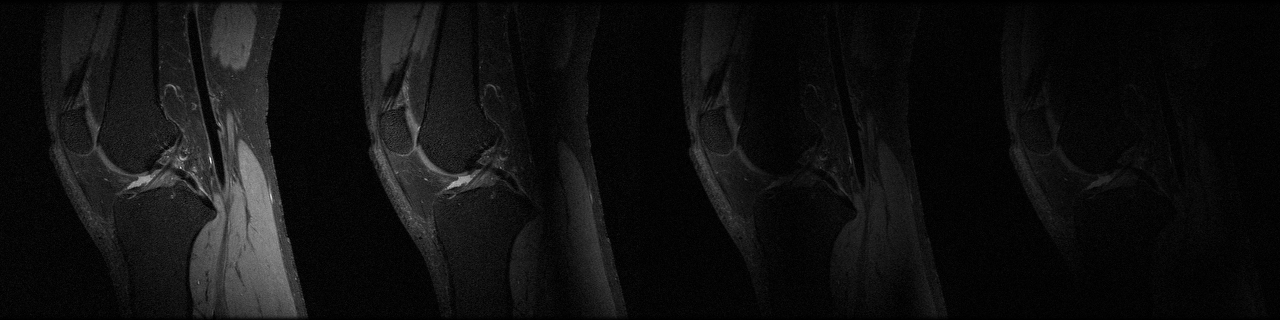

In [47]:
imshow knee_cc_flat

We can consolidate this process into a bash function that generalizes to arbitrary slice dimensions and number  of coils. 

Usage: `flatten <data> <output>`

In [24]:
function flatten(){
    # The flattened image's dimensions are calculated as (num coils) * (slice dims)
    # get the slice dimensions and number of coils
    let slice_dim=$(bart show -d 1 $1)
    let coils=$(bart show -d 3 $1)
    
    let "flat_dim = slice_dim * coils"
    
    bart reshape $(bart bitmask 1 3) $flat_dim 1 $1 $2
}

Now let's look at our uncompressed FFT data, across eight coils.

In [25]:
flatten knee_uncompressed slice_flat

Writing 1 image(s)...done.


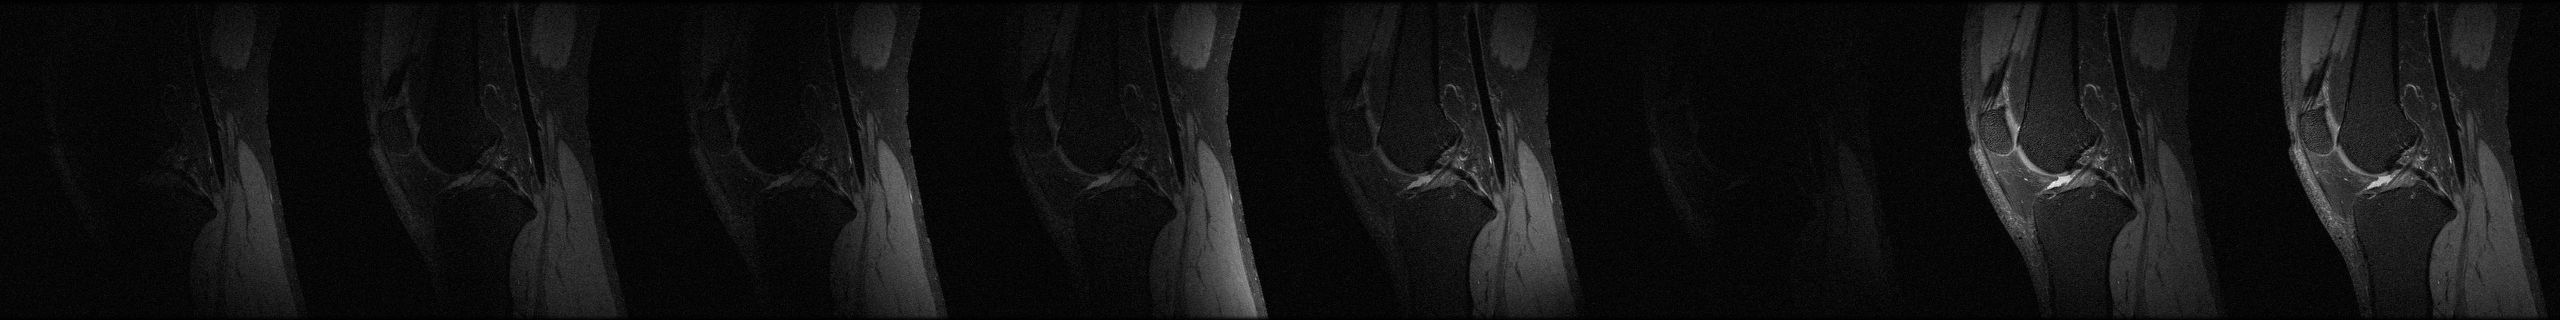

In [48]:
imshow slice_flat

Compare the differing sensitivities to observe the effect of compression to four virtual coils. Double-click the images to enlarge.

### Combining Multi-Coil Images

Let's combine the compressed images via a Root Sum-Of-Squares (`rss`) message. 

In [27]:
bart rss -h

Usage: rss bitmask <input> <output>

Calculates root of sum of squares along selected dimensions.

-h		help


In [28]:
bart rss $(bart bitmask 3) knee_cc knee

Writing 1 image(s)...done.


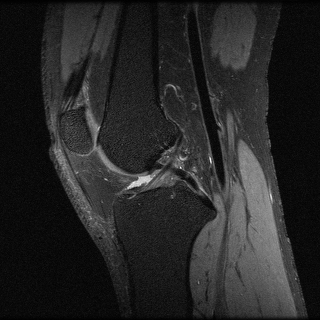

In [49]:
imshow knee

## Scripting the Pipeline

Finally, we will consolidate the basic tools above into a Bash script that automates this reconstruction with detailed output at each step. We'll then show how this function makes it easy to reconstruct each slice of our 3D data.

USAGE: `slice_recon <data> <slice>`

In [30]:
bart slice -h

Usage: slice dim1 pos1 ... dimn posn <input> <output>

Extracts a slice from positions along dimensions.


-h		help


In [31]:
function slice_recon() {
    
    echo "[INFO] Performing inverse FFT along the readout direction..."
    bart fft -i -u $(bart bitmask 2) $1 readout_fft
    
    echo "[INFO] Extracting slice..."
    bart slice 2 $1 readout_fft slice
    
    echo "[INFO] Performing coil compression on the slice..."
    bart cc -p 4 -G slice slice_cc
    
    echo "[INFO] Performing FFT on the image..."
    bart fft -i -u $(bart bitmask 0 1) slice_cc slice_fft
    
    echo "[INFO] Combining coil compressed images..."
    bart rss $(bart bitmask 3) slice_fft final

}

In [ ]:
# Cleanup
rm *.cfl *.hdr